In [1]:
!pip install albumentations

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow.keras.layers import Dense, Input, Average, Embedding, Layer, Add, Flatten, Normalization, Resizing
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Rescaling, GaussianNoise
import tensorflow.keras.applications as tfApp
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dense
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skimage.util import random_noise

import albumentations as alb

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

In [3]:
random_gen = np.random.RandomState(seed=0)

### Functions

In [4]:
multiple_neutrophil = 5
def get_dataframe_from_directory(path, oversampling=False, test_size=0.1, oversampled_drop_ratio=1.0):
    paths = []
    labels = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if '.jpeg' in filename:
                path = dirname + '/' + filename
                paths.append(path)
                labels.append(os.path.split(dirname)[-1])
    data_df = pd.DataFrame({'path': paths, 'label': labels})
    train_df, valid_df = train_test_split(data_df, 
                                        stratify=data_df['label'],
                                        test_size=test_size,
                                        random_state=0)

    if oversampling == True:
        from imblearn.over_sampling import RandomOverSampler
        rosampler = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = rosampler.fit_resample(
                                        train_df['path'].to_numpy().reshape(-1, 1),
                                        train_df['label'])
        train_df = pd.DataFrame({'path':X_resampled.reshape(-1), 'label':y_resampled})
        if oversampled_drop_ratio < 1.0 and oversampled_drop_ratio > 0:
            train_df = train_df.drop(
                        random_gen.choice(train_df[train_df['label']=='NEUTROPHIL'].index,
                        int(len(train_df[train_df['label']=='NEUTROPHIL'])*oversampled_drop_ratio),
                        replace=False))
    else:
        if multiple_neutrophil > 1:
            # print("befor : ", len(train_df))
            neutrophil_data = pd.concat([train_df[train_df['label']=='NEUTROPHIL']]*multiple_neutrophil, ignore_index=True)
            # print("neutrophil_data : ", len(neutrophil_data))
            train_df = pd.concat([train_df, neutrophil_data], ignore_index=True)
            # print("after : ", len(train_df))
    return train_df, valid_df

In [5]:
def preprocess_input_with_noise(x):
  x /= 127.5
  x -= 1.
  x = random_noise(x, mode='gaussian')
  return x

In [6]:
def make_image_generator(train_df, valid_df, target_size, batch_size,
                seed=None, preprocessing=True, noise=False, rotation=45, width_shift=0.1,
                height_shift=0.1, shear=0.1, zoom=0.2, x_col='path', y_col='label',
                preprocessing_function=None):
    if preprocessing == True and preprocessing_function is None:
        if noise == True:
            preprocessing_function = preprocess_input_with_noise
        else:
            preprocessing_function = preprocess_input

    train_image_gen = ImageDataGenerator(rotation_range=rotation, height_shift_range=height_shift,
                          width_shift_range=width_shift, shear_range=shear, 
                          zoom_range=zoom, horizontal_flip=True, vertical_flip=True,
                          preprocessing_function=preprocessing_function)
    if preprocessing == False:
        preprocessing_function = None                       
    val_image_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_data_gen = train_image_gen.flow_from_dataframe(dataframe=train_df,
                            target_size=target_size,
                            shuffle=True,
                            batch_size=batch_size,
                            class_mode='sparse',
                            seed=seed,
                            x_col=x_col, y_col=y_col)
    val_data_gen = val_image_gen.flow_from_dataframe(dataframe=valid_df,
                                target_size=target_size,
                                shuffle=True,
                                batch_size=batch_size,
                                class_mode='sparse',
                                seed=seed,
                                x_col=x_col, y_col=y_col)

    labels_values = train_df['label'].value_counts()
    labels_count = len(labels_values)
    class_weight = ((1/labels_values) * (len(train_df)/len(labels_values))).rename(train_data_gen.class_indices)
    return train_data_gen, val_data_gen, labels_count, class_weight

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x


class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(inputs,#input_shape,
                        input_shape,
                        patch_size=6, 
                        projection_dim=64,
                        num_heads=4,
                        transformer_layers=8,
                        mlp_head_units = [2048, 1024]):
    if inputs == None:
        if input_shape == None:
            raise AttributeError                      
        inputs = Input(shape=input_shape)
    else:
        input_shape = inputs.get_shape().as_list()[1:3]
    image_size=input_shape[0]
    num_patches = (image_size // patch_size) ** 2
    transformer_units = [
        projection_dim * 2,
        projection_dim]

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = Dense(units=num_classes, activation='softmax')(features)
    # Create the Keras model.
    #model = Model(inputs=inputs, outputs=features)
    return inputs, features

In [8]:
def apply_preprocess(name, preprocessors, inputs):
    preprocessing_list = preprocessors.get(name, None)
    if preprocessing_list is not None:
        for processor in preprocessing_list:
            inputs = processor(inputs)
        return inputs
    return None
        
def make_model(app_names, input_shape, classes, preprocessors=None):
    model_inputs = Input(input_shape)
    model_oupts = []
    for name in app_names:
        if preprocessors is not None:
            inputs = apply_preprocess(name, preprocessors, model_inputs)
            if inputs is None:
                inputs = model_inputs
        else:
            inputs = model_inputs

        if name.lower() == 'vit':
            _, keras_app = create_vit_classifier(inputs, input_shape)
        else:
            keras_app = getattr(tfApp, name)
            params = {
                'include_top':False,
                'weights':None,
                'input_shape':input_shape,
                'pooling':'avg',
            }
            if 'include_preprocessing' in keras_app.__code__.co_varnames:
                params['include_preprocessing'] = False
            keras_app = keras_app(**params)(inputs)
        fc = Dense(units=classes, activation='softmax')(keras_app)
        model_oupts.append(fc)
    if len(model_oupts) > 1:
        output = Average()(model_oupts)
    else:
        output = model_oupts[0]
    model = Model(inputs=model_inputs, outputs=output)
    return model

In [29]:
def predict_and_save(model, image_size, test_path, class_names, file_path, preprocess_function):
    test_file_name = []
    predicted_class = []
    for dirname, _, filenames in os.walk(test_path):
        for filename in filenames:
            if '.jpeg' in filename:
                path = dirname + '/' + filename
                test_file_name.append(filename)
                img = load_img(path, target_size=image_size)
                img = image.img_to_array(img)
                if preprocess_function is not None:
                    img = preprocess_input(img)                
                img = img.reshape((1,) + img.shape)
                predicted_class.append(class_names[np.argmax(model.predict(img))])
    pd.DataFrame({'Filename': test_file_name, 'Prediction': predicted_class}).sort_values(by=['Filename']).to_csv(file_path, index=False)

In [10]:
from sklearn.metrics import confusion_matrix
from glob import glob
import itertools

def make_confusion_matrix(model, data_path, image_size, batch_size, preprocessing_function=None):
  image_files = glob(data_path + '/*/*.jp*g')
  print(f"Making confusiuon matrix of {len(image_files)} files")
  predictions = []
  targets = []
  val_image_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
  val_data_gen = val_image_gen.flow_from_directory(data_path,
                                            target_size=image_size, 
                                            shuffle=False,
                                            batch_size=batch_size * 2)
  for x, y in val_data_gen:
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= len(image_files):
      break

  cm = confusion_matrix(targets, predictions)
  print(classification_report(targets, predictions, target_names=val_data_gen.class_indices.keys()))
  return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

### Enviorments

In [11]:
train_path = 'data/train'
test_path = 'data/test/all'
oversampled_drop_ratio = 1.0
# oversampled_drop_ratio = 0.3
train_df, valid_df = get_dataframe_from_directory(train_path)
ov_train_df, ov_valid_df = get_dataframe_from_directory(train_path, oversampling=True, oversampled_drop_ratio=oversampled_drop_ratio)
len(ov_train_df)

8988

### Hyper-parameters

In [12]:
# ResNet50V2 input shape
IMAGE_SIZE = [224, 224]
IMAGE_SHAPE = tuple(IMAGE_SIZE) + (3, )

# 17321MiB
epochs = 100
batch_size = 32

# Image Augmentation
rotation=20
width_shift=0.1
height_shift=0.1
shear=0.1
zoom=0.2

#CosineDecay
init_lr = 0.001
decay_steps = 40
alpha = 0.01

patience = epochs/2

### Make data generators

In [13]:
train_data_gen, val_data_gen, labels_count, class_weight = make_image_generator(train_df, valid_df, IMAGE_SIZE, batch_size)
class_names = dict(zip(train_data_gen.class_indices.values(), train_data_gen.class_indices.keys()))

Found 7119 validated image filenames belonging to 4 classes.
Found 754 validated image filenames belonging to 4 classes.


##### oversampling data generator

In [14]:
ov_train_data_gen, ov_val_data_gen, _, ov_class_weight = make_image_generator(ov_train_df, ov_valid_df, IMAGE_SIZE, batch_size, noise=True)

Found 8988 validated image filenames belonging to 4 classes.
Found 754 validated image filenames belonging to 4 classes.


In [15]:
def run_model(apps, 
            image_size=[224, 224],
            batch_size=32,
            epochs=100,
            learning_rate=0.001,
            patience=20,
            oversamling=False,
            using_cw=False,
            noise=False,
            preprocessing=True,
            preprocessors=None,
            preprocessing_function=None,
            seed=None,
            cp_path='./cp.ckpt'):
    image_shape = tuple(image_size) + (3, )
    if oversamling == True:
        tdf = ov_train_df
        vdf = ov_valid_df
    else:
        tdf = train_df
        vdf = valid_df

    tdata_gen, vdata_gen, label_count, class_weight = make_image_generator(tdf, vdf,
                                                                        image_size, 
                                                                        batch_size,
                                                                        seed=seed,
                                                                        preprocessing=preprocessing,
                                                                        noise=noise,
                                                                        preprocessing_function=preprocessing_function)

    print(class_weight)
    model = make_model(apps,
                    image_shape,
                    label_count,
                    preprocessors=preprocessors)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            optimizer=Adam(learning_rate=learning_rate),
            metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

    if using_cw == False:
        class_weight = None
    else:
        class_weight = class_weight.to_dict()
    
    result = model.fit(
        tdata_gen,
        validation_data=vdata_gen,
        epochs=epochs,
        steps_per_epoch=len(tdf) // batch_size,
        validation_steps=len(vdata_gen) // batch_size,
        class_weight=class_weight,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=patience, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=cp_path,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True),
    ])
    return model, result

### 1. 실행 가능 모델

keras가 지원하는 모델 (version 2.8 기준)
|Model|
|:---:|
|Xception|
|VGG16|
|VGG19|
|ResNet50|
|ResNet50V2|
|ResNet101|
|ResNet101V2|
|ResNet152|
|ResNet152V2|
|InceptionV3|
|InceptionResNetV2|
|MobileNet|
|MobileNetV2|
|DenseNet121|
|DenseNet169|
|DenseNet201|
|NASNetMobile|
|NASNetLarge|
|EfficientNetB0|
|EfficientNetB1|
|EfficientNetB2|
|EfficientNetB3|
|EfficientNetB4|
|EfficientNetB5|
|EfficientNetB6|
|EfficientNetB7|
|EfficientNetV2B0|
|EfficientNetV2B1|
|EfficientNetV2B2|
|EfficientNetV2B3|
|EfficientNetV2S|
|EfficientNetV2M|
|EfficientNetV2L|
|EfficientNetV2B0|
|EfficientNetV2B1|
|EfficientNetV2B2|
|EfficientNetV2B3|
|EfficientNetV2S|
|EfficientNetV2M|
|EfficientNetV2L|

추가로 VIT model 생성 가능
|Model|
|:---:|
|VIT|

### 2. Single Model
- model : inceptionResNet
- oversampling : True
- learning rate : cosine decay scheduler 적용
- random noise : True
- class weight : False
- patience : 미적용(patience를 epochs와 동일하게 설정)
- image size : 299, 299
- batch size : 16
- epochs : 60

    ```python
    init_lr = 0.001
    decay_steps = 40
    alpha = 0.01
    lr_decayed_fn = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)
    epochs = 60
    model, result = run_model(['InceptionResNetV2'],
                            [299, 299], 
                            16, 
                            epochs=epochs, 
                            learning_rate=lr_decayed_fn, 
                            oversamling=True,
                            noise=True, 
                            using_cw=False, 
                            patience=epochs)
    ```

### 3. Ensemble Model
- model : InceptionV3, DenseNet
- oversampling : True
- learning rate : 0.0001
- random noise : True
- class weight : False
- patience : 미적용(patience를 epochs와 동일하게 설정)
- image size : 244, 244
- batch size : 32
- epochs : 60

    ```python
    epochs : 60
    model, result = run_model(['DenseNet', 'InceptionV3'],
                            [224, 224], 
                            32, 
                            epochs=epochs, 
                            learning_rate=0.0001, 
                            oversamling=True,
                            noise=True, 
                            using_cw=False, 
                            patience=epochs)
    ```

In [16]:
import albumentations as alb
def preprocess_input_image(x):
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.5, 2.0)
    x = tf.image.random_saturation(x, 0.75, 1.25).numpy()
    alpha = random_gen.randint(2, 4)
    transform = alb.Compose([
        alb.ElasticTransform(always_apply=False,
                        p=0.5,
                        alpha=alpha, sigma=1, 
                        alpha_affine=5,
                        mask_value=None,
                        approximate=False),
        alb.GridDistortion(always_apply=False, 
                        p=0.5, 
                        num_steps=1,
                        distort_limit=(-0.1, 0.1), 
                        mask_value=None)
                ])
    transformed = transform(image=x)
    x = transformed["image"]
    return x

image_size = [224, 224]
epochs = 100
batch_size = 16
init_lr = 0.0001
decay_steps = (len(train_df)//batch_size)*(epochs/3)
alpha = 0.01
t_mul=1.0
m_mul=0.2
epochs = 40
cp_path='./efficientnetv2s.cp.ckpt'

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecayRestarts(init_lr, 
                                                decay_steps,
                                                alpha=alpha,
                                                t_mul=t_mul,
                                                m_mul=m_mul)

model, result = run_model(['EfficientNetV2S'],
                        image_size, 
                        batch_size, 
                        epochs=epochs, 
                        learning_rate=lr_decayed_fn, 
                        oversamling=False,
                        noise=False, 
                        using_cw=True,
                        patience=epochs,
                        preprocessing=False,
                        preprocessors={
                            'EfficientNetV2S':[Rescaling(scale=1./128.0, offset=-1)]
                        },
                        preprocessing_function=preprocess_input_image,
                        seed=0,
                        cp_path=cp_path)
# model, result = run_model(['ResNet50V2', 'InceptionV3', 'DenseNet121', 'EfficientNetV2B0'],
#                         image_size, 
#                         batch_size, 
#                         epochs=epochs, 
#                         learning_rate=lr_decayed_fn, 
#                         oversamling=True,
#                         noise=False, 
#                         using_cw=False, 
#                         patience=epochs,
#                         preprocessing=False,
#                         preprocessors={
#                             'ResNet50V2': [Rescaling(scale=1./128.0, offset=-1), GaussianNoise(0.1)],
#                             'InceptionV3': [Rescaling(scale=1./128.0, offset=-1), GaussianNoise(0.1)],
#                             'DenseNet121': [Rescaling(scale=1./128.0, offset=-1), GaussianNoise(0.1)],
#                             'EfficientNetV2B0':[
#                                 Rescaling(scale=1./255),
#                                 Normalization(mean=[0.485, 0.456, 0.406],
#                                             variance=[0.229**2, 0.224**2, 0.225**2],
#                                             axis=3,)]
#                         })

Found 7119 validated image filenames belonging to 4 classes.
Found 754 validated image filenames belonging to 4 classes.
0    0.792056
1    0.796665
2    0.798094
3    4.362132
Name: label, dtype: float64
Epoch 1/40
444/444 [==============================] - 138s 282ms/step - loss: 1.3602 - accuracy: 0.3158 - val_loss: 1.1101 - val_accuracy: 0.5833
Epoch 2/40
444/444 [==============================] - 126s 283ms/step - loss: 1.0194 - accuracy: 0.5531 - val_loss: 0.6200 - val_accuracy: 0.7500
Epoch 3/40
444/444 [==============================] - 129s 285ms/step - loss: 0.7519 - accuracy: 0.6953 - val_loss: 0.4122 - val_accuracy: 0.8542
Epoch 4/40
444/444 [==============================] - 124s 279ms/step - loss: 0.5988 - accuracy: 0.7597 - val_loss: 0.4846 - val_accuracy: 0.8125
Epoch 5/40
444/444 [==============================] - 126s 283ms/step - loss: 0.4884 - accuracy: 0.8088 - val_loss: 0.3809 - val_accuracy: 0.8333
Epoch 6/40
444/444 [==============================] - 127s 285ms/

min validation loss:  0.00044704359606839716


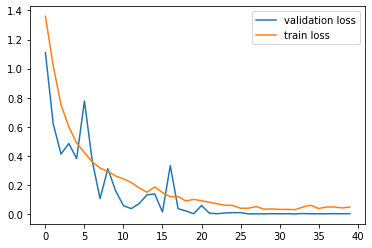

In [17]:
print("min validation loss: ", np.min(result.history['val_loss']))
plt.plot(result.history['val_loss'], label='validation loss')
plt.plot(result.history['loss'], label='train loss')
plt.legend()
plt.show()

max validation accuracy:  1.0


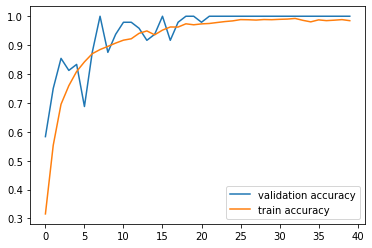

In [18]:
print("max validation accuracy: ", np.max(result.history['val_accuracy']))
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.plot(result.history['accuracy'], label='train accuracy')
plt.legend()
plt.show()

In [22]:
model.load_weights(cp_path)

In [30]:
predict_and_save(model, image_size, test_path, class_names, "./team2.efficentnetv2s.b16.0.9059.csv", preprocess_function=None)

In [31]:
model.save('model.efficentnetv2s.b16.h5')